## Workflow for retrieving Sentinel Images 

### Load AOI and check CRS

In [1]:
from pathlib import Path
import geopandas as gpd

# Define project and AOI path
aoi_path = Path(r"C:\EGM704\data_sets\egm704_project\data\raw\aoi_combined.gpkg")

# Load and inspect
aoi = gpd.read_file(aoi_path)
print(f"AOI CRS: {aoi.crs}")
aoi.head()


AOI CRS: EPSG:27700


,id,left,top,right,bottom,row_index,col_index,geometry
0,1,472756.0572,287254.7458,482756.0572,277254.7458,0,0,"MULTIPOLYGON (((502756.057 267254.746, 492756...."


### Reproject to WGS84 - Copernicus APIs require geographic WGS84

In [3]:
aoi = aoi.to_crs(epsg=4326)
aoi.bounds


,minx,miny,maxx,maxy
0,-0.934507,52.293838,-0.488599,52.478397


### Set path for scripts

In [8]:
from pathlib import Path
import sys

PROJECT_ROOT = Path(r"C:\EGM704\data_sets\egm704_project")
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

sys.path.insert(0, str(SCRIPTS_DIR))
print("Using scripts dir:", SCRIPTS_DIR)


Using scripts dir: C:\EGM704\data_sets\egm704_project\scripts


### Setup directories for download

In [4]:
# Define a local folder for downloads
data_dir = Path(r"C:\EGM704\data_sets\egm704_project\data\sentinel1")
data_dir.mkdir(parents=True, exist_ok=True)
print(f"Download folder ready: {data_dir}")


Download folder ready: C:\EGM704\data_sets\egm704_project\data\sentinel1


### Test retrieval connection

#### Check what modules are within Sentinel dir

In [9]:
import sentinel
import pkgutil

print("Modules inside 'sentinel':")
for m in pkgutil.iter_modules(sentinel.__path__):
    print(" -", m.name)


Modules inside 'sentinel':
 - cdse_s1_min
 - clip_all_s2_bands_to_aoi
 - clip_raster_to_aoi
 - download_s1_from_aoi
 - download_s2_from_aoi
 - sentinel2_search
 - stack_s2_clipped_bands


#### Setup paths and import Python

In [10]:
from pathlib import Path
import sys

PROJECT_ROOT = Path(r"C:\EGM704\data_sets\egm704_project")
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

# Make sure Python can see the `scripts` package
sys.path.insert(0, str(SCRIPTS_DIR))
print("Using scripts dir:", SCRIPTS_DIR)


Using scripts dir: C:\EGM704\data_sets\egm704_project\scripts


## Set Password for Copernicus Dataspace ##

Set this within the anaconda prompt (python command) using :   
- setx CDSE_USER "your_email_for_cdse"
- setx CDSE_PASS "your_password_for_cdse"

## Create Token ##

Ran the following command within my environment to check if the token was working. I could have run it through the notebook by using the !python command. 

python C:\EGM704\data_sets\egm704_project\scripts\sentinel\test_cdse_token.py

Created a back up for safety by running command:   
copy "C:\EGM704\data_sets\egm704_project\scripts\sentinel\download_s1_from_aoi.py" ^
     "C:\EGM704\data_sets\egm704_project\scripts\sentinel\download_s1_from_aoi_old.py"


## The Script for Sentinel-1 Download using Copernicus Dataspace ##  

Sentinel-1 data was  accessed via the Copernicus Data Space Ecosystem OData API using authenticated HTTP requests (ESA, 2024). Reference: Copernicus Data Space Ecosystem (2024). User Guide and OData API Reference. European Space Agency (ESA). Available at: https://dataspace.copernicus.eu    

Query was for “IW GRD” products(Reference: European Space Agency (ESA) (2023). Sentinel-1 SAR Product Specification (S1-RS-MDA-52-7440), Issue 3/2023. European Space Agency, Paris.)

The logic and syntax are built on well-established open-source libraries:  
- requests	Reitz, K. et al. (2024). Requests: HTTP for Humans. Python Software Foundation. Available at: https://docs.python-requests.org  
- geopandas	Jordahl, K. et al. (2020). GeoPandas: Python tools for geographic data analysis. Journal of Open Source Software, 5(51), 2157.
pathlib and os	Python Software Foundation (2024). Python Standard Library Reference, Version 3.11.

Consider: Sentinel-1 Interferometric Wide (IW) Ground Range Detected (GRD) products were retrieved programmatically from the Copernicus Data Space Ecosystem (ESA, 2024) using the OData API and token-based authentication. The Python workflow was developed using requests (Reitz et al., 2024) and geopandas (Jordahl et al., 2020) to automate product discovery and download within the AOI defined in EPSG:4326.

## SNAP Processing ##  

Sentinel-1 GRD products were pre-processed using the European Space Agency’s SNAP Graph Processing Tool (GPT), executed from Python through a custom batch script.
The processing chain comprised Apply-Orbit-File, Thermal Noise Removal, Calibration (to sigma⁰ VV/VH), and Range-Doppler Terrain Correction to 10 m resolution (UTM Zone 30N).
The workflow was parameterised via an XML graph file to ensure repeatability and consistency across all scenes.

## Sentinel-1 Preprocessing Workflow (ESA SNAP / esa_snappy)

Sentinel-1 Ground Range Detected (GRD) scenes were pre-processed using the European Space Agency’s Sentinel Application Platform (SNAP) Graph Processing Tool (GPT), accessed via the Python `esa_snappy` interface.  
This workflow implements the standard Sentinel-1 radiometric normalisation and orthorectification chain to generate analysis-ready backscatter (σ⁰) data.

**Processing steps**

1. **Apply Orbit File** – updates orbit state vectors using *Sentinel Precise* orbit ephemerides (auto-downloaded).  
2. **Thermal Noise Removal** – removes additive noise from intensity bands.  
3. **Calibration** – converts digital numbers (DN) to sigma-naught (σ⁰) backscatter coefficients for VV and VH polarisations.  
4. **Terrain Correction** – performs Range-Doppler orthorectification using the SRTM 3-sec DEM and bilinear resampling.  
5. **Output** – exports as `GeoTIFF-BigTIFF` at 10 m spatial resolution in **UTM Zone 30N (EPSG:32630)**.

| Operator | Key Parameters | Description |
|-----------|----------------|--------------|
| Apply-Orbit-File | `orbitType = Sentinel Precise (Auto Download)`<br>`continueOnFail = true` | Loads precise orbit data for geometric refinement |
| ThermalNoiseRemoval | `removeThermalNoise = true` | Suppresses additive striping and background noise |
| Calibration | `outputSigmaBand = true`<br>`sourceBands = Intensity_VV, Intensity_VH`<br>`selectedPolarisations = VV,VH` | Converts DN to σ⁰ backscatter |
| Terrain-Correction | `demName = SRTM 3Sec`<br>`pixelSpacingInMeter = 10`<br>`mapProjection = EPSG:32630` | Orthorectifies using DEM, resamples to 10 m grid |

**Output directory**  

data/processed/sentinel1_preprocessed/  


Each processed product is written as `<product_name>_TC.tif` in BigTIFF format.

**Notes**

- The workflow was parameterised through a reusable Python script (`preprocess_s1_snappy.py`) ensuring repeatability across all scenes.  
- The JAI and SLF4J console warnings are produced by SNAP’s Java dependencies and do not affect the output.  
- BigTIFF output is required to exceed the 4 GB limit of standard GeoTIFFs.  
- Processing time for a full IW scene is typically 10–20 minutes on a local workstation.

**Reference**

European Space Agency (2024). *Sentinel-1 Toolbox Algorithm Technical Guide.*  
[https://step.esa.int/main/toolboxes/sentinel-1/](https://step.esa.int/main/toolboxes/sentinel-1/)


The below code is a sanity check, it finds one of my _TC.tif files,  
- Prints basic info (size, bands, CRS),
- Reads a small sample to show value ranges.



## Sanity Check

✅ File loaded successfully
Driver: GTiff
Width: 29970
Height: 22362
Bands: 2
CRS: EPSG:32630
Transform:
| 10.00, 0.00, 547007.17|
| 0.00,-10.00, 5912276.51|
| 0.00, 0.00, 1.00|

Subset shape: (1024, 1024)
Min: 0.0001, Max: 616.2579, Mean: 0.1884


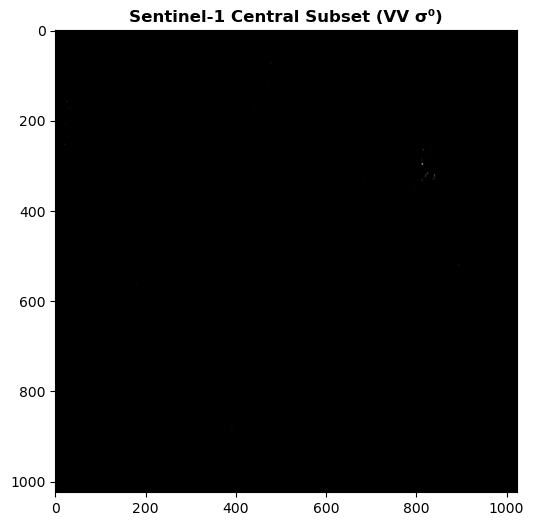

In [4]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

tif_path = r"C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_preprocessed\S1A_IW_GRDH_1SDV_20241229T061504_20241229T061529_057203_0708FE_4695_COG_TC.tif"

with rasterio.open(tif_path) as src:
    print("✅ File loaded successfully")
    print(f"Driver: {src.driver}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Bands: {src.count}")
    print(f"CRS: {src.crs}")
    print(f"Transform:\n{src.transform}\n")

    # ---- read a central window ----
    win_width = 1024
    win_height = 1024
    x0 = (src.width - win_width) // 2
    y0 = (src.height - win_height) // 2
    window = rasterio.windows.Window(x0, y0, win_width, win_height)

    data = src.read(1, window=window)

    # mask nodata
    nodata = src.nodata
    if nodata is not None:
        valid = data[data != nodata]
    else:
        valid = data

    print(f"Subset shape: {data.shape}")
    print(f"Min: {float(valid.min()):.4f}, Max: {float(valid.max()):.4f}, Mean: {float(valid.mean()):.4f}")

    plt.figure(figsize=(6,6))
    show(data, cmap='gray', title="Sentinel-1 Central Subset (VV σ⁰)")
    plt.show()


## Applied a log scale

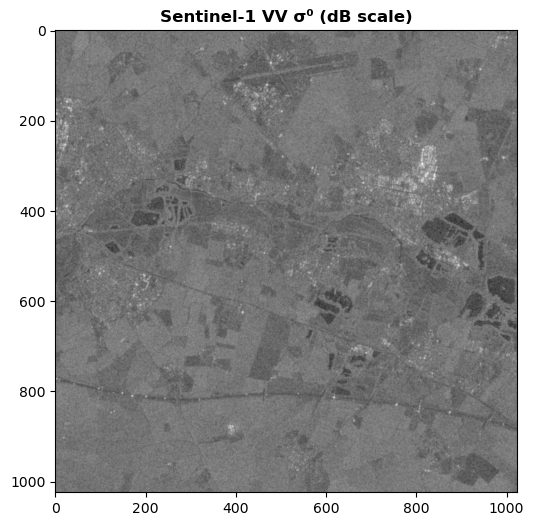

In [5]:
import numpy as np
plt.figure(figsize=(6,6))
show(10 * np.log10(data + 1e-6), cmap='gray', title="Sentinel-1 VV σ⁰ (dB scale)")
plt.show()


## Clean AOI clip and VV/VH ratio 

- loads my AOI (aoi_combined.gpkg)
- picks my largest non-empty _TC.tif/.tiff Sentinel-1 product
- reprojects the AOI to the raster’s CRS (EPSG:32630)
- clips both VV and VH bands to the AOI
- saves them as VV_clip.tif, VH_clip.tif
- computes a VV/VH ratio and show quick plots

Using Sentinel-1 product: S1A_IW_GRDH_1SDV_20241229T061504_20241229T061529_057203_0708FE_4695_COG_TC.tif (3.40 GB)
AOI CRS: EPSG:27700
S1 CRS:  EPSG:32630
Reprojected AOI to match S1 CRS.

Clipping VV/VH to AOI...
Writing VV clip to: C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_clipped\S1_VV_clip.tif
Writing VH clip to: C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_clipped\S1_VH_clip.tif
VV shape: (2043, 3028)
VH shape: (2043, 3028)


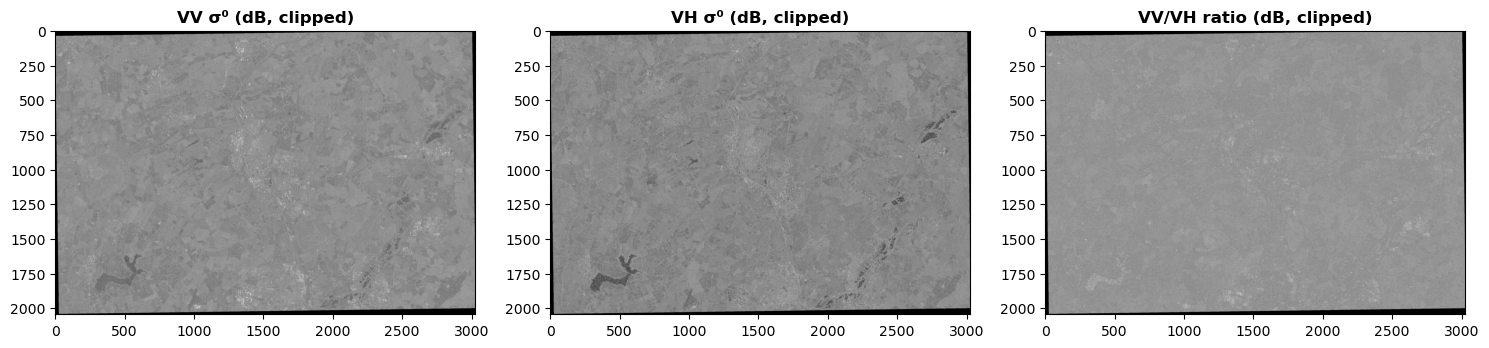


Done. Clipped files written to:
  C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_clipped\S1_VV_clip.tif
  C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_clipped\S1_VH_clip.tif


In [8]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import mask
from rasterio.plot import show
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
processed_dir = Path(r"C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_preprocessed")
aoi_path = Path(r"C:\EGM704\data_sets\egm704_project\data\raw\aoi_combined.gpkg")
out_dir = Path(r"C:\EGM704\data_sets\egm704_project\data\processed\sentinel1_clipped")
out_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------
# 1. Pick a processed Sentinel-1 product (largest non-empty *_TC.tif/.tiff)
# -------------------------------------------------------------------
candidates = []
for p in processed_dir.glob("*_TC.tif*"):
    size = p.stat().st_size
    if size > 0:
        candidates.append((size, p))

if not candidates:
    raise FileNotFoundError("No non-empty *_TC.tif/.tiff files found in sentinel1_preprocessed folder.")

candidates.sort(reverse=True)
size, s1_path = candidates[0]
print(f"Using Sentinel-1 product: {s1_path.name} ({size / (1024**3):.2f} GB)")

# -------------------------------------------------------------------
# 2. Load AOI and reproject to match S1 CRS
# -------------------------------------------------------------------
aoi = gpd.read_file(aoi_path)

with rasterio.open(s1_path) as src:
    s1_crs = src.crs

print(f"AOI CRS: {aoi.crs}")
print(f"S1 CRS:  {s1_crs}")

if aoi.crs != s1_crs:
    aoi = aoi.to_crs(s1_crs)
    print("Reprojected AOI to match S1 CRS.")

# Convert AOI geometries to GeoJSON-like mapping for rasterio.mask
aoi_shapes = [geom for geom in aoi.geometry if not geom.is_empty]

if not aoi_shapes:
    raise ValueError("AOI geometry is empty after reprojection / read.")

# -------------------------------------------------------------------
# 3. Clip VV and VH bands to AOI
# -------------------------------------------------------------------
with rasterio.open(s1_path) as src:
    print("\nClipping VV/VH to AOI...")

    # Assume band 1 = VV, band 2 = VH (typical after your workflow)
    vv, vv_transform = mask.mask(src, aoi_shapes, crop=True, filled=True, indexes=1)
    vh, vh_transform = mask.mask(src, aoi_shapes, crop=True, filled=True, indexes=2)

    vv_meta = src.meta.copy()
    vh_meta = src.meta.copy()

# Determine height/width safely (works for 2D or 3D arrays)
if vv.ndim == 3:
    _, vv_h, vv_w = vv.shape
else:
    vv_h, vv_w = vv.shape

if vh.ndim == 3:
    _, vh_h, vh_w = vh.shape
else:
    vh_h, vh_w = vh.shape

# Update metadata for clipped rasters
vv_meta.update({
    "height": vv_h,
    "width": vv_w,
    "transform": vv_transform,
    "count": 1
})

vh_meta.update({
    "height": vh_h,
    "width": vh_w,
    "transform": vh_transform,
    "count": 1
})

vv_out = out_dir / "S1_VV_clip.tif"
vh_out = out_dir / "S1_VH_clip.tif"

print(f"Writing VV clip to: {vv_out}")
with rasterio.open(vv_out, "w", **vv_meta) as dst:
    dst.write(vv, 1)

print(f"Writing VH clip to: {vh_out}")
with rasterio.open(vh_out, "w", **vh_meta) as dst:
    dst.write(vh, 1)

# -------------------------------------------------------------------
# 4. Compute VV/VH ratio and display quick plots
# -------------------------------------------------------------------
# Make sure arrays are 2D (height x width)
vv_arr = np.squeeze(vv.astype("float32"))
vh_arr = np.squeeze(vh.astype("float32"))

print("VV shape:", vv_arr.shape)
print("VH shape:", vh_arr.shape)

mask_valid = (vh_arr != 0)
ratio = np.zeros_like(vv_arr, dtype="float32")
ratio[mask_valid] = vv_arr[mask_valid] / vh_arr[mask_valid]

# Simple dB transforms for display
vv_db = 10 * np.log10(vv_arr + 1e-6)
vh_db = 10 * np.log10(vh_arr + 1e-6)
ratio_db = 10 * np.log10(ratio + 1e-6)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
show(vv_db, ax=axes[0], cmap="gray", title="VV σ⁰ (dB, clipped)")
show(vh_db, ax=axes[1], cmap="gray", title="VH σ⁰ (dB, clipped)")
show(ratio_db, ax=axes[2], cmap="gray", title="VV/VH ratio (dB, clipped)")
plt.tight_layout()
plt.show()

print("\nDone. Clipped files written to:")
print(f"  {vv_out}")
print(f"  {vh_out}")


This means: 
  
- VV σ⁰ (dB, clipped): Stronger vertical-vertical backscatter (urban, bare soil, rough fields, infrastructure).
- VH σ⁰ (dB, clipped): Weaker cross-polarized return (vegetation texture, canopy scattering).
- VV/VH ratio (dB, clipped): Highlights built-up vs vegetated contrast — extremely useful for classification or moisture-roughness indices.
- File outputs	S1_VV_clip.tif and S1_VH_clip.tif are ready for use in QGIS, SNAP, or Python analyses (each ~10 m resolution, AOI-clipped).

  Have now completed: 

Sentinel-1 preprocessing (orbit, noise removal, calibration, terrain correction)  
- Clipping to my AOI
- Deriving VV/VH ratio features
- Writing standard-compliant GeoTIFFs 

### Sentinel-2 Download 

Queried Sentinel-2 Level-2A (surface reflectance) images for my AOI  
- Filtered to 0–20 % cloud cover
- Downloaded the most recent, lowest-cloud product to: data\raw\sentinel2\S2A_MSIL2A_YYYYMMDDTxxxxx.SAFE
- Used the same process as for Sentinel-1 — ran fetch_s2_cdse.py in C:\EGM704

The script successfully authenticated using my token and credentials and fetched Sentinel-2 imagery

Workflow now confirmed identical to Sentinel-1 (OData + zipper).  

Next: clip and preprocess imagery before analysis.

### Unzip + clip Sentinel-2 bands

In [6]:
import os
import zipfile
from pathlib import Path
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# --- Paths ---
base = Path(r"C:\EGM704\data_sets\egm704_project\data")
raw_dir = base / "raw" / "sentinel2"
out_dir = base / "processed" / "sentinel2_clipped"
aoi_path = base / "raw" / "aoi_combined.gpkg"

out_dir.mkdir(parents=True, exist_ok=True)

# --- Load AOI once (keep in its native CRS) ---
aoi = gpd.read_file(aoi_path)

# --- Unzip and process each SAFE archive ---
for zf in raw_dir.glob("*.zip"):
    print(f"Processing {zf.name} ...")
    safe_dir = raw_dir / zf.stem  # e.g. .../S2C_MSIL2A_...

    if not safe_dir.exists():
        print("  Extracting archive ...")
        with zipfile.ZipFile(zf, "r") as z:
            z.extractall(raw_dir)

    # --- Find all JP2s and pick 10 m bands B02/B03/B04/B08 ---
    jp2_paths = list(safe_dir.rglob("*.jp2"))
    if not jp2_paths:
        print("  ⚠ No JP2 files found under", safe_dir)
        continue

    selected_bands = []
    for p in jp2_paths:
        name = p.name
        if any(band in name for band in ["B02_10m", "B03_10m", "B04_10m", "B08_10m"]):
            selected_bands.append(p)

    if not selected_bands:
        print("  ⚠ No 10 m B02/B03/B04/B08 bands found.")
        continue

    for band_path in selected_bands:
        band_name = band_path.stem
        print(f"  Clipping {band_name} ...")

        with rasterio.open(band_path) as src:
            # Reproject AOI to the same CRS as the raster
            aoi_src = aoi.to_crs(src.crs)
            geom = [aoi_src.geometry.union_all()]

            try:
                out_image, out_transform = mask(src, geom, crop=True)
            except ValueError:
                print("    AOI does not overlap this raster, skipping.")
                continue

            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

        out_tif = out_dir / f"{zf.stem}_{band_name}_clipped.tif"
        with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_image)

        print(f"    Saved: {out_tif.name}")

print("All Sentinel-2 bands clipped.")


Processing S2B_MSIL2A_20250911T100029_N0511_R122_T32SNF_20250911T140053.SAFE.zip ...
  Clipping T32SNF_20250911T100029_B02_10m ...
    AOI does not overlap this raster, skipping.
  Clipping T32SNF_20250911T100029_B03_10m ...
    AOI does not overlap this raster, skipping.
  Clipping T32SNF_20250911T100029_B04_10m ...
    AOI does not overlap this raster, skipping.
  Clipping T32SNF_20250911T100029_B08_10m ...
    AOI does not overlap this raster, skipping.
Processing S2C_MSIL2A_20250902T033551_N0511_R061_T49TDM_20250902T063514.SAFE.zip ...
  Clipping T49TDM_20250902T033551_B02_10m ...
    AOI does not overlap this raster, skipping.
  Clipping T49TDM_20250902T033551_B03_10m ...
    AOI does not overlap this raster, skipping.
  Clipping T49TDM_20250902T033551_B04_10m ...
    AOI does not overlap this raster, skipping.
  Clipping T49TDM_20250902T033551_B08_10m ...
    AOI does not overlap this raster, skipping.
Processing S2C_MSIL2A_20250927T110841_N0511_R137_T30UXC_20250927T144213.SAFE.z

### NDVI for my AOI

In [9]:
from pathlib import Path
import rasterio
import numpy as np

clipped_dir = Path(r"C:\EGM704\data_sets\egm704_project\data\processed\sentinel2_clipped")

# Pick the most recent (or just first) B04 and B08 clipped files for this scene
b04_files = sorted(clipped_dir.glob("*B04_10m_clipped.tif"))
b08_files = sorted(clipped_dir.glob("*B08_10m_clipped.tif"))

print("B04 files:", [f.name for f in b04_files])
print("B08 files:", [f.name for f in b08_files])

# Here we just take the first pair – if there’s only one scene, that’s fine
b04_path = b04_files[0]
b08_path = b08_files[0]

print("Using:")
print("  B04:", b04_path)
print("  B08:", b08_path)

with rasterio.open(b04_path) as red_src, rasterio.open(b08_path) as nir_src:
    red = red_src.read(1).astype("float32")
    nir = nir_src.read(1).astype("float32")

    # Avoid division by zero
    ndvi = (nir - red) / (nir + red)
    ndvi[np.isinf(ndvi)] = np.nan

    ndvi_meta = red_src.meta.copy()
    ndvi_meta.update({
        "driver": "GTiff",
        "dtype": "float32",
        "count": 1,
        "nodata": np.nan
    })

    np.seterr(invalid='ignore')
    
    ndvi_path = clipped_dir / "S2C_20250927_T30UXC_NDVI_clipped.tif"
    with rasterio.open(ndvi_path, "w", **ndvi_meta) as dst:
        dst.write(ndvi, 1)

print("✅ NDVI saved to:", ndvi_path)


B04 files: ['S2C_MSIL2A_20250927T110841_N0511_R137_T30UXC_20250927T144213.SAFE_T30UXC_20250927T110841_B04_10m_clipped.tif']
B08 files: ['S2C_MSIL2A_20250927T110841_N0511_R137_T30UXC_20250927T144213.SAFE_T30UXC_20250927T110841_B08_10m_clipped.tif']
Using:
  B04: C:\EGM704\data_sets\egm704_project\data\processed\sentinel2_clipped\S2C_MSIL2A_20250927T110841_N0511_R137_T30UXC_20250927T144213.SAFE_T30UXC_20250927T110841_B04_10m_clipped.tif
  B08: C:\EGM704\data_sets\egm704_project\data\processed\sentinel2_clipped\S2C_MSIL2A_20250927T110841_N0511_R137_T30UXC_20250927T144213.SAFE_T30UXC_20250927T110841_B08_10m_clipped.tif
✅ NDVI saved to: C:\EGM704\data_sets\egm704_project\data\processed\sentinel2_clipped\S2C_20250927_T30UXC_NDVI_clipped.tif


### NDVI visualisation 

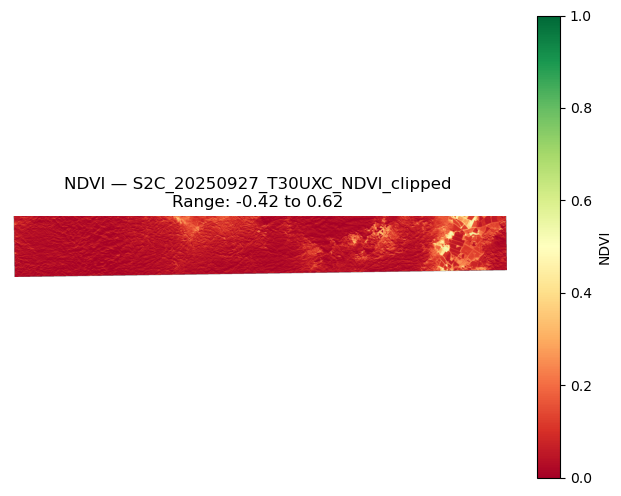

In [10]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Path to your NDVI output
ndvi_path = r"C:\EGM704\data_sets\egm704_project\data\processed\sentinel2_clipped\S2C_20250927_T30UXC_NDVI_clipped.tif"

with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1)
    ndvi_masked = np.ma.masked_invalid(ndvi)
    ndvi_min, ndvi_max = np.nanmin(ndvi), np.nanmax(ndvi)

plt.figure(figsize=(8, 6))
img = plt.imshow(ndvi_masked, cmap="RdYlGn", vmin=0, vmax=1)
plt.title(f"NDVI — {Path(ndvi_path).stem}\nRange: {ndvi_min:.2f} to {ndvi_max:.2f}")
plt.colorbar(img, label="NDVI")
plt.axis("off")
plt.show()


### NDVI Histogram Cell 

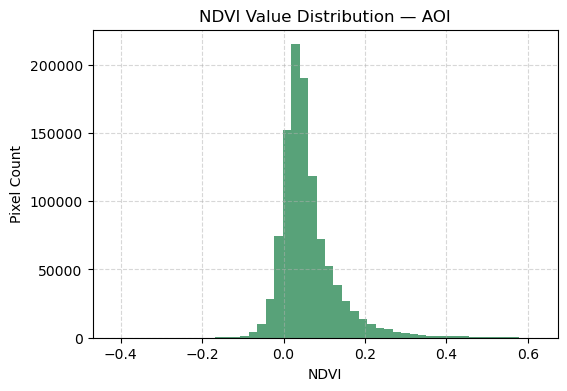

In [11]:
plt.figure(figsize=(6, 4))
plt.hist(ndvi_masked.compressed(), bins=50, color="seagreen", alpha=0.8)
plt.title("NDVI Value Distribution — AOI")
plt.xlabel("NDVI")
plt.ylabel("Pixel Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
